## **Classez des images**

### partie 2/4 : modèle perso

<br>

> #### notebook de mise en oeuvre de création et d’entraînement du modèle personnel, des simulations des différentes valeurs des hyperparamètres et de data augmentation.. <br><br>

<br>


## 0 Imports


### 0.1 Librairies, réglages


In [1]:
# paths, folders/files
import os, sys, random, re
from os import listdir
from glob import glob
from zipfile import ZipFile
import time

# math, dataframes
import numpy as np
import pandas as pd
from pandarallel import pandarallel
from collections import Counter

# Visualisation
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import plotly.express as px
# from wordcloud import WordCloud
# from PIL import Image

# Feature engineering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn import manifold, decomposition
from sklearn import cluster, metrics
from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer

# NN
import tensorflow as tf
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

import keras_tuner as kt
import optuna
%pip install optuna-integration
from optuna_integration import TFKerasPruningCallback

# tracking
from mlflow import MlflowClient
import mlflow.keras

# ! REQUIRES CONSOLE COMMAND : mlflow ui
# depuis dossier notebooks
os.environ['MLFLOW_TRACKING_URI'] = './'
# Utilisable seulement en local ?
mlflow.set_tracking_uri("http://localhost:5000")
client = MlflowClient(tracking_uri="http://127.0.0.1:5000")

import pickle

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical


print('\nPython version ' + sys.version)
print('Tensorflow version ' + tf.__version__)
print('Mlflow Autolog compatible with: 2.2.4 <= keras <= 2.6.0')
print('Keras version ' + tf.keras.__version__)
# no autolog... ?

# plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

# Modify if necessary
num_cores = os.cpu_count()
print(f"\nNumber of CPU cores: {num_cores}")
pandarallel.initialize(progress_bar=False, nb_workers=6)


2024-03-30 07:44:35.728409: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Note: you may need to restart the kernel to use updated packages.

Python version 3.11.5 (main, Sep 11 2023, 13:23:44) [GCC 11.2.0]
Tensorflow version 2.12.0
Mlflow Autolog compatible with: 2.2.4 <= keras <= 2.6.0
Keras version 2.12.0

Number of CPU cores: 8
INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### 0.2 Variables globales


In [2]:
nb_classes = 3      # min 2, max 120

size_wh = 128
target_size=(size_wh, size_wh) # pour grille 5x5, stride (2,2) ?

test_size = 0.15 # same for validation

alea = 42 # pour fixer les ttsplits et tjs travailler sur les mm datasets
# En revanche l'initialisation des poids des modèles restera aléatoire,
# pour pouvoir comparer les resultats sur +ieurs runs.

epochs = 15

nb_runs = 50 # 2-3 le matin, 50-100 le soir

pickle_path_model = './pickle_best/ze_model.pkl'
pickle_path_accuracy = './pickle_best/best_accuracy_val.pkl'
pickle_path_params = './pickle_best/best_params.pkl'

try:
    best_acc = pickle.load(open(pickle_path_accuracy, 'rb'))
    best_parameters = pickle.load(open(pickle_path_params, 'rb'))
except:
    best_acc = 0.3

print(best_acc, '\n')
pprint(best_parameters)


0.7692307829856873 

{'activation': 'tanh',
 'conv_1_units': 12,
 'conv_2_units': 20,
 'dense_units': 192,
 'dim images': '128 x 128 x 3',
 'feature': 'originale, photo_path',
 'model': 'V3',
 'nb epochs': 15,
 'preprocessing': 'norm',
 'size val test sets': 0.15,
 'target': '3_classes',
 'tuner/bracket': 1,
 'tuner/epochs': 15,
 'tuner/initial_epoch': 5,
 'tuner/round': 1,
 'tuner/trial_id': '0019'}


### 0.3 Fonctions


In [3]:
# tracking manuel

model_results = []

def affichage_results(multiple=True, best_acc=best_acc):
    """Tracking manuel de nos modèles (data, params, tps, scores) pour comparaison."""

    print(f'{nb_classes} classes prédites')
    print(f'dim images : {size_wh} x {size_wh} x 3')
    print(f'size validation & testing sets : {test_size}')
    print(f'nb epochs : {epochs}', '\n')
    print(f'current best accuracy (validation set) : {best_acc}')

    if multiple:
        print(f'nb runs: {nb_runs}', '\n')

    # Create a DataFrame from the list of model results
    model_comparison_df = pd.concat([pd.DataFrame(model_results)], ignore_index=True)

    # Sort the DataFrame by precision in descending order (higher is better)
    model_comparison_df.sort_values(by='accuracy_val_moy', ascending=False, inplace=True)

    # Display the sorted DataFrame
    display(model_comparison_df)


# tracking mlflow

def create_mlflow_experiment(
    experiment_name: str, artifact_location: str, tags: dict[str, str]
) -> str:
    """
    Create a new mlflow experiment with the given name and artifact location.

    Parameters:
    ----------
    experiment_name: str
        The name of the experiment to create.
    artifact_location: str
        The artifact location of the experiment to create.
    tags: dict[str,Any]
        The tags of the experiment to create.

    Returns:
    -------
    experiment_id: str
        The id of the created experiment.
    """
    try:
        experiment_id = mlflow.create_experiment(
            name=experiment_name, artifact_location=artifact_location, tags=tags
        )
    except:
        print(f"Experiment {experiment_name} already exists.")
        experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

    mlflow.set_experiment(experiment_name=experiment_name)

    return experiment_id


def get_mlflow_experiment(
    experiment_id: str = None, experiment_name: str = None
) -> mlflow.entities.Experiment:
    """
    Retrieve the mlflow experiment with the given id or name.

    Parameters:
    ----------
    experiment_id: str
        The id of the experiment to retrieve.
    experiment_name: str
        The name of the experiment to retrieve.

    Returns:
    -------
    experiment: mlflow.entities.Experiment
        The mlflow experiment with the given id or name.
    """
    if experiment_id is not None:
        experiment = mlflow.get_experiment(experiment_id)
    elif experiment_name is not None:
        experiment = mlflow.get_experiment_by_name(experiment_name)
    else:
        raise ValueError("Either experiment_id or experiment_name must be provided.")

    return experiment


### 0.4 Metriques


In [4]:
# J'utiliserai tjs les noms anglais des métriques ici,
# pour éviter la confusion précision (fr) != precision (en),
# et pour simplement garder les noms des fonctions importées depuis tf.keras.metrics

# Nous sommes dans un cas de classification "classique", 1 classe prédite.
# Une première métrique simple et intuitive est donc l'accuracy :
# nb de prédictions correctes / nb total de prédictions.
# Cette métrique nous suffit déjà pour comparer et optimiser nos modèles.

# Si l'on souhaite étudier + en détail les prédictions des modèles, on utilisera
# la precison et le recall

# Precison (TP / (TP + FP)) :
# Une précision élevée signifie que si une classe est prédite par le modèle,
# alors il y a une forte probabilité (égale à la precision)
# que le chien appartienne en effet à cette classe.

# Recall (TP / (TP + FN)) :
# pour évaluer la capacité des modèles à identifier toutes les instances positives.
# Exemple : Si notre precision est égale à 1, c'est parfais, cela signifie que
# pour une une classe au moins, toutes les valeurs prédites par le modèle sont correctes.
# Cependant, il est possible que cela ne concerne que très peu de cas (mettons, 1 ou 2 prédictions)
# et qu'à côté de cela le modèle a pu faire des milliers de prédictions incorrectes,
# la precision seule ne nous le dit pas.

# Comme l'amélioration de la precision se fait svt au détriment du recall, en pratique
# on combine souvent les 2 avec le f1score (= moyenne harmonique)
# (2 x precision x recall) / (precision + recall)
# qui nous donne directement une idée du compromis precision / recall

# petit souci : le f1score et keras, c'est tout une histoire...
# Dans les versions récentes (depuis la 2.15.0 il me semble), le f1score est directement intégré
# au module metrics. Le problème est que conda n'arrive pas à résoudre un env avec ces versions,
# incompatibles avec les requirements d'autres packages dans l'env.

# Dans les versions + anciennes de keras, le f1score était dans un autre module, "addons",
# mais ce moule est désormais déprécié.
# Solutions : définir un f1score custom
# Pas évident car tensorflow est très pointilleux sur les types d'objets qu'il accepte.
# Exemple : cette fonction est construite en utilisant 2 fonctions tf.keras,
# pourtant elle renvoit une erreur si on tente de l'utiliser parce que le type retourné est
# un float.

def f1score(y_true, y_pred):
    precision = Precision(y_true, y_pred)
    recall = Recall(y_true, y_pred)
    f1 = (2*precision*recall) / (precision + recall)

    return f1

# Autre solution, utiliser le f1score de sk-learn. Compatibilité logging mlflow ?

metrics=[
    'Accuracy',
    # f1score,
    # AUC(),
]


### 0.4 Data


In [5]:
data = pd.read_csv('./data/data_3_classes.csv', sep=',')

print(data.shape)
data.head()


(723, 8)


,photo_path,breed,width,height,resized,expo,contraste,denoised
0,./data/cleaned_data/0_format/-maltese_dog/n020...,maltese_dog,500,333,./data/cleaned_data/1_resized_128/-maltese_dog...,./data/cleaned_data/2_expo_128/-maltese_dog/n0...,./data/cleaned_data/3_contraste_128/-maltese_d...,./data/cleaned_data/4_gauss_denoised_128/-malt...
1,./data/cleaned_data/0_format/-maltese_dog/n020...,maltese_dog,500,375,./data/cleaned_data/1_resized_128/-maltese_dog...,./data/cleaned_data/2_expo_128/-maltese_dog/n0...,./data/cleaned_data/3_contraste_128/-maltese_d...,./data/cleaned_data/4_gauss_denoised_128/-malt...
2,./data/cleaned_data/0_format/-maltese_dog/n020...,maltese_dog,400,500,./data/cleaned_data/1_resized_128/-maltese_dog...,./data/cleaned_data/2_expo_128/-maltese_dog/n0...,./data/cleaned_data/3_contraste_128/-maltese_d...,./data/cleaned_data/4_gauss_denoised_128/-malt...
3,./data/cleaned_data/0_format/-maltese_dog/n020...,maltese_dog,500,333,./data/cleaned_data/1_resized_128/-maltese_dog...,./data/cleaned_data/2_expo_128/-maltese_dog/n0...,./data/cleaned_data/3_contraste_128/-maltese_d...,./data/cleaned_data/4_gauss_denoised_128/-malt...
4,./data/cleaned_data/0_format/-maltese_dog/n020...,maltese_dog,500,375,./data/cleaned_data/1_resized_128/-maltese_dog...,./data/cleaned_data/2_expo_128/-maltese_dog/n0...,./data/cleaned_data/3_contraste_128/-maltese_d...,./data/cleaned_data/4_gauss_denoised_128/-malt...


### 0.5 Etude de faisabilité (sort of)


In [6]:
# Ici l'étude de faisabilité préconisée par la méthode Agile n'est pas vraiment utile en tant que telle
# (On sait que le projet est faisable). Il s'agit plutôt de pouvoir observer le travail effectué par le
# bloc d'encodage, sans utiliser d'algorithme de prediction supervisée
# (algo classique ou plutôt, ici, bloc des layers fully connected)

images_features = []

for image_file in data["photo_path"] :
    image = load_img(image_file, target_size=(180, 180))
    image = img_to_array(image)
    images_features.append(image)

images_features = np.asarray(images_features)
images_features.shape


(723, 180, 180, 3)

In [7]:
# Reshape images to flatten them into vectors
flattened_images = images_features.reshape(images_features.shape[0], -1)
print(flattened_images.shape)

# Normalize the data
scaler = StandardScaler()
normalized_images = scaler.fit_transform(flattened_images)


(723, 97200)


### 0.6 Réduction dim


In [8]:
# PCA

print(normalized_images.shape) # same as flattened_images

pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(normalized_images)

print(feat_pca.shape)

# dimention divisée par 200 (presque), en conservant 99% de la variance !


(723, 97200)
(723, 610)


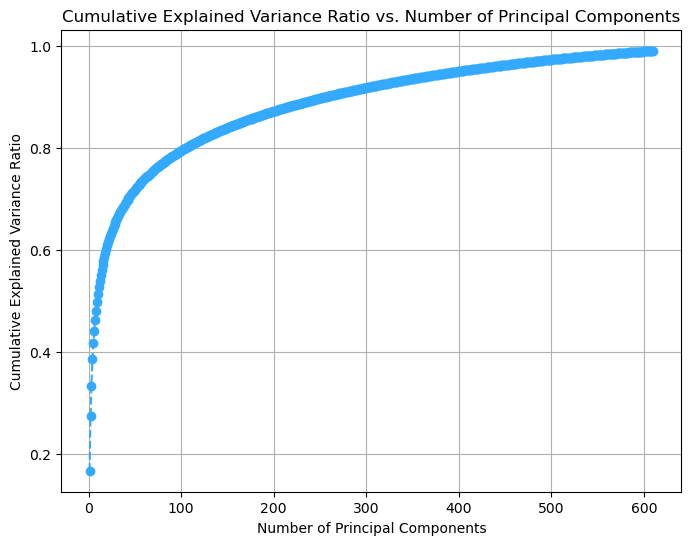

In [9]:
# Plot explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--', color='#3af')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Principal Components')
plt.grid(True)
plt.show()

# Pourquoi on a besoin du tsne pour la visu : en 2D ou même en 3D, les 3 premiers vecteurs propres
# # fournis par la PCA ne captent "que" (environ) un tiers de l'information.
# Ce qu'on verrait serait très déformé par les projections successives de la PCA.
# tester ?


### 0.7 tsne


In [10]:
# t-sne

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)


In [11]:
# encodage target

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(data["breed"])

data["target"] = label_encoder.transform(data["breed"])

display(data.head(1))
data.tail(1)


,photo_path,breed,width,height,resized,expo,contraste,denoised,target
0,./data/cleaned_data/0_format/-maltese_dog/n020...,maltese_dog,500,333,./data/cleaned_data/1_resized_128/-maltese_dog...,./data/cleaned_data/2_expo_128/-maltese_dog/n0...,./data/cleaned_data/3_contraste_128/-maltese_d...,./data/cleaned_data/4_gauss_denoised_128/-malt...,1


,photo_path,breed,width,height,resized,expo,contraste,denoised,target
722,./data/cleaned_data/0_format/-scottish_deerhou...,scottish_deerhound,500,402,./data/cleaned_data/1_resized_128/-scottish_de...,./data/cleaned_data/2_expo_128/-scottish_deerh...,./data/cleaned_data/3_contraste_128/-scottish_...,./data/cleaned_data/4_gauss_denoised_128/-scot...,2


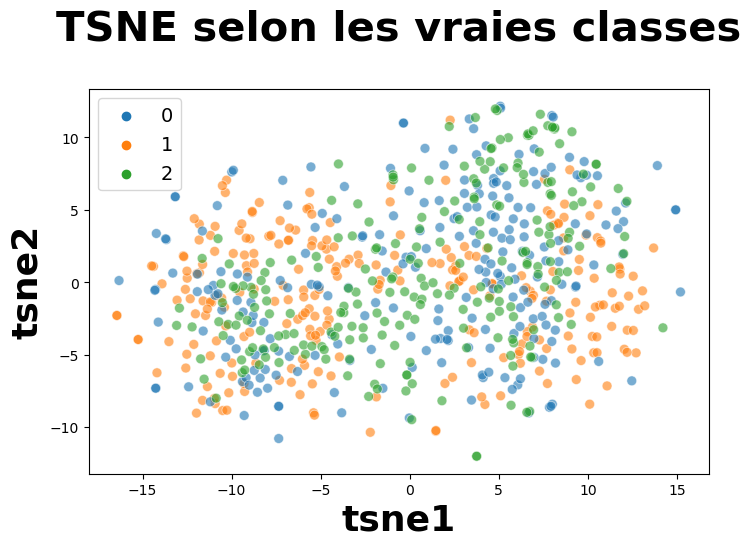

In [12]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["target"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=3), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

plt.show()

# Ca marche moins bien sans extraction de features !
# On retentera en fin de notebook, en utilisant notre modèle.


### 1 Création d'un premier modèle


In [13]:
# Notre objectifs principal ici est
# de pouvoir observer / comprendre la fonction des différentes layers utilisées.

# Pour cela, nous allons commencer par une architecture très simple :
# le but n'est pas d'avoir le modèle le + performant possible.
# (irréaliste ici car on n'aurait ni le tps ni les ressources pour l'entrainer)
# (en revanche, voir le notebook 3, transfer learning, pour une comparaison de modèles + complexes)

# Première idée :
# Notre modèle de base sera donc inspiré d'AlexNet, dont l'architecture est :

# "AlexNet contains eight layers: the first five are convolutional layers,
# some of them followed by max-pooling layers, and the last three are fully connected layers.
# [...] The entire structure can be written as:

# (CNN -> RN -> MP)^2 -> (CNN^3 -> MP) -> (FC -> DO)^2 -> Linear -> softmax

# where
# CNN = convolutional layer (with ReLU activation)
# RN = local response normalization
# MP = maxpooling
# FC = fully connected layer (with ReLU activation)
# Linear = fully connected layer (without activation)
# DO = dropout

# It used the non-saturating ReLU activation function, which showed improved training performance
# over tanh and sigmoid." (wiki)


### 1.1 LeNet inspired architecture


In [14]:
# Problème : 8 groupes de layers... (16 individuelles, en fait) C'est déjà beaucoup !
# On peut faire + simple, au moins pour commencer.

# Voyons de quoi sera capable un modèle inspiré plutôt par LeNet-5
# et par ce notebook : https://www.kaggle.com/code/schmoyote/simple-cnn-architecture-for-image-classification/notebook


def model_v1():
    model = Sequential()
    model.add(Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(size_wh, size_wh, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, kernel_size=(5, 5), activation='tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    # model.add(Dense(120, activation='tanh'))
    model.add(Dense(60, activation='tanh'))
    model.add(Dense(nb_classes, activation='softmax'))

    return model


model = model_v1()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 6)       456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 13456)             0         
                                                                 
 dense (Dense)               (None, 60)                8

2024-03-29 21:20:56.165955: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### 1.2 feature engineering


In [15]:
feature = "photo_path"


def feature_to_array(feature="photo_path", norm=False, shape_result=False):
    X_feature = []

    for image_file in data[feature] :
        image = load_img(image_file, target_size=target_size)
        image = img_to_array(image)
        if norm:
            image = image / 255
        X_feature.append(image)

    X_feature = np.asarray(X_feature)

    if shape_result:
        pprint(X_feature[:1])
        print('\n', "Shape of X_train:", X_feature.shape)
        # ok

    return X_feature


X_feature = feature_to_array(shape_result=True)


array([[[[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [178., 198., 223.],
         [176., 196., 221.],
         [175., 195., 220.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [178., 198., 223.],
         [177., 197., 222.],
         [176., 196., 221.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [179., 199., 224.],
         [178., 198., 223.],
         [177., 197., 221.]],

        ...,

        [[188., 171., 155.],
         [133., 116., 100.],
         [152., 135., 119.],
         ...,
         [ 62.,  44.,  24.],
         [ 50.,  34.,  18.],
         [ 44.,  44.,  18.]],

        [[ 94.,  86.,  75.],
         [ 91.,  83.,  72.],
         [ 80.,  72.,  61.],
         ...,
         [111.,  94.,  78.],
         [160., 148., 134.],
         [178., 145., 128.]],

        [[208., 194., 181.],
       

### 1.3 label encoding target


In [16]:
y_target = np.asarray(data["target"])
print(y_target.shape)
pprint(y_target)


(723,)
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

### 1.4 train test split


In [17]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_feature, y_target, test_size=test_size,
                                                            shuffle=True, random_state=alea,
                                                            stratify=y_target) # important

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=test_size,
                                                            shuffle=True, random_state=alea,
                                                            stratify=y_train_val)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape, '\n')

print(y_train.shape)
print(y_val.shape)
print(y_test.shape, '\n')


(521, 128, 128, 3)
(93, 128, 128, 3)
(109, 128, 128, 3) 

(521,)
(93,)
(109,) 



### 1.5 one hot encoding (targets)


In [18]:
# One-hot encode target values after the split to avoid data leakage

y_train_ohe = tf.keras.utils.to_categorical(y_train)
y_val_ohe = tf.keras.utils.to_categorical(y_val)
y_test_ohe = tf.keras.utils.to_categorical(y_test)


### 1.6 Training


In [19]:
# Train the model
model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=32,
          validation_data=(X_val, y_val_ohe))


Epoch 1/15
17/17 [==============================] - 3s 151ms/step - loss: 4.3105 - Accuracy: 0.3359 - val_loss: 3.9222 - val_Accuracy: 0.3226
Epoch 2/15
17/17 [==============================] - 2s 139ms/step - loss: 3.5904 - Accuracy: 0.3205 - val_loss: 3.1977 - val_Accuracy: 0.3226
Epoch 3/15
17/17 [==============================] - 2s 132ms/step - loss: 3.0129 - Accuracy: 0.3013 - val_loss: 2.6808 - val_Accuracy: 0.3226
Epoch 4/15
17/17 [==============================] - 3s 160ms/step - loss: 2.4619 - Accuracy: 0.3205 - val_loss: 2.1254 - val_Accuracy: 0.3226
Epoch 5/15
17/17 [==============================] - 2s 145ms/step - loss: 1.8993 - Accuracy: 0.3205 - val_loss: 1.5864 - val_Accuracy: 0.3226
Epoch 6/15
17/17 [==============================] - 2s 142ms/step - loss: 1.4085 - Accuracy: 0.3205 - val_loss: 1.2100 - val_Accuracy: 0.3226
Epoch 7/15
17/17 [==============================] - 3s 156ms/step - loss: 1.1435 - Accuracy: 0.3205 - val_loss: 1.1023 - val_Accuracy: 0.3226
Epoch 

### 1.7 Evaluation


In [20]:
# On overfit dès le début ??

# Evaluate the model
val_loss_ref, val_acc_ref = model.evaluate(X_val, y_val_ohe)
print(f'Val accuracy: {val_acc_ref}', '\n')

# En prédisant au hasard on aurait une chance sur 3, autrement dit
# ce modèle fait des prédictions quasi-aléatoires.
# Pas terrible, mais c'est un début !

# avant, tester sur photos d'origine (pour évaluer l'utilité du prétraitement effectué)



3/3 [==============================] - 0s 39ms/step - loss: 1.0985 - Accuracy: 0.3441
Val accuracy: 0.34408602118492126 



### save


In [21]:
parameters = {
    "model": "V1",
    "preprocessing": 'no_norm',
    "feature": feature,
    'target': f'{nb_classes}_classes',
    'dim images': f'{size_wh} x {size_wh} x 3',
    'size val test sets': test_size,
    'nb epochs': epochs
}


def save_model_if_better_than_the_best(model=model, acc=val_acc_ref, best_params=parameters):

    global best_acc

    if acc > best_acc:
        print(f'Improving! Accuracy up to {acc}')
        best_acc = acc
        # erreur logging, saving instead
        # using mlflow
        # mlflow.keras.save_model(model, "./best_model") # works only once
        # using pickle
        with open(pickle_path_model, 'wb') as f:
            pickle.dump(model, f)
        # also save best accuracy
        with open(pickle_path_accuracy, 'wb') as f:
            pickle.dump(best_acc, f)
        # and corresponding best params
        with open(pickle_path_params, 'wb') as f:
            pickle.dump(best_params, f)


save_model_if_better_than_the_best()


In [22]:
# petit tracking manuel
results = {'model': 'V1',
            'df': 'data_3_classes',
            'feature': feature,
            'accuracy_val_moy': val_acc_ref,
            'time_fit': 'to do',
            'time_predict':'to do'
            }

# Append a new row for this model
model_results.append(results)


### 1.8 test utilité prétraitements


In [23]:
experiment_id = create_mlflow_experiment(
    experiment_name="analyse_pretraitements",
    artifact_location="./mlruns/artifacts",
    tags={"model": "V1", "preprocessing": 'no_norm', "features": "4_processed_features", 'target': '3_classes'},
)


Experiment analyse_pretraitements already exists.


In [24]:
# resized


def test_feature(df=data, feature='photo_path', epochs=epochs):
    parameters = {
        "model": "V1",
        "preprocessing": 'no_norm',
        "feature": feature,
        'target': f'{nb_classes}_classes',
        'dim images': f'{size_wh} x {size_wh} x 3',
        'size val test sets': test_size,
        'nb epochs': epochs
    }
    mlflow.log_params(parameters)

    # feature, target
    X_feature = feature_to_array(feature)
    y_target = np.asarray(df["target"])

    #tt split
    X_train_val, X_test, y_train_val, y_test = train_test_split(X_feature, y_target, test_size=0.1,
                                                                shuffle=True, random_state=alea,
                                                                stratify=y_target) # important

    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1,
                                                                shuffle=True, random_state=alea,
                                                                stratify=y_train_val)

    # ohe cible
    y_train_ohe = tf.keras.utils.to_categorical(y_train)
    y_val_ohe = tf.keras.utils.to_categorical(y_val)
    y_test_ohe = tf.keras.utils.to_categorical(y_test)

    # model
    model = model_v1()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

    model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=32,
            validation_data=(X_val, y_val_ohe))

    _, val_acc = model.evaluate(X_val, y_val_ohe)

    save_model_if_better_than_the_best(model=model, acc=val_acc, best_params=parameters)

    metrix = {
        "accuracy_val": val_acc
    }
    # multiple metrics
    mlflow.log_metrics(metrix)

    print(f'Val accuracy (feature={feature}): {val_acc}')

    results = {'model': 'V1',
            'df': 'data_3_classes',
            'feature': feature,
            'accuracy_val_moy': val_acc,
            'time_fit': 'to do',
            'time_predict':'to do'
            }

    # Append a new row for this model
    model_results.append(results)

    return val_acc


# _ = test_feature(df=data, feature='resized')


# 0.6 de precision sans pretraitement (parfois 0.3 ??), 0.3 avec.
# Notre prétraitement semble (très) contre-productif. Ajuster dim, filtres ? (trop flou ?)
# Comme prétraitement, les méthodes .preprocessing() de keras consistent svt seulement en
# redimensionnemt + normalisation.
# faire pareil ?


In [25]:
# nested

features_to_test = ['resized', 'expo', 'contraste', 'denoised']


experiment = get_mlflow_experiment(experiment_id=experiment_id)
print("Name: {}".format(experiment.name))

with mlflow.start_run(run_name="4_processed_features_once", experiment_id=experiment_id) as parent:
    all_metrics = {}

    for feature in features_to_test:
        print('\n', feature)
        with mlflow.start_run(run_name=f'{feature}', nested=True) as child:
            print(f'RUN ID child_{feature}: {child.info.run_id}', '\n')
            accuracy_val = test_feature(df=data, feature=feature)
            all_metrics[f'accuracy_{feature}'] = accuracy_val

    print('\n')
    pprint(all_metrics)
    mlflow.log_metrics(all_metrics)

# results
# 'resized' 0.32 ???
# 'expo' 0.63
# 'contraste' 0.32

# rappel
print(f'\nRappel : Val accuracy (photo_path original): {val_acc_ref}')


Name: analyse_pretraitements

 resized
RUN ID child_resized: 4297034a08f64c1f95dca196a07ad458 



Epoch 1/15
19/19 [==============================] - 4s 156ms/step - loss: 4.0822 - Accuracy: 0.3214 - val_loss: 3.4940 - val_Accuracy: 0.3231
Epoch 2/15
19/19 [==============================] - 3s 141ms/step - loss: 2.7297 - Accuracy: 0.3179 - val_loss: 1.0992 - val_Accuracy: 0.3538
Epoch 3/15
19/19 [==============================] - 3s 167ms/step - loss: 1.0980 - Accuracy: 0.3470 - val_loss: 1.0983 - val_Accuracy: 0.3538
Epoch 4/15
19/19 [==============================] - 3s 142ms/step - loss: 1.1006 - Accuracy: 0.3197 - val_loss: 1.0984 - val_Accuracy: 0.3538
Epoch 5/15
19/19 [==============================] - 3s 136ms/step - loss: 1.0989 - Accuracy: 0.3145 - val_loss: 1.0978 - val_Accuracy: 0.3538
Epoch 6/15
19/19 [==============================] - 4s 189ms/step - loss: 1.1011 - Accuracy: 0.3470 - val_loss: 1.0980 - val_Accuracy: 0.3538
Epoch 7/15
19/19 [==============================] - 3s 172ms/step - loss: 1.0989 - Accuracy: 0.3470 - val_loss: 1.0984 - val_Accuracy: 0.3231
Epoch 

### Comparaison


In [26]:
affichage_results(multiple=False, best_acc=best_acc)

# On y voit déjà (un peu) + clair :
# Chaque étape de notre prétraitement semble + ou - détériorer la qualité des prédictions.

# Encore que... ?
# ??? resized et photo_path devraient donner des résultats bien + proches, non ??
# sets identiques sauf dim, et redim lors de création de X_feature
# ... devraient être exactement identiques, et donc avoir des resultats proches

# En fait d'un run à l'autre, les prédictions varient énormément...
# difficile du coup d'évaluer l'impact de nos prétraitements.
# moyenne sur +ieurs runs ?

model_results = []

# (Très) svt le modèle ne parvient pas à "train ses layers", et l'accuracy des prédictions
# sur le jeu de validation reste au niveau de prédictions random.


3 classes prédites
dim images : 128 x 128 x 3
size validation & testing sets : 0.15
nb epochs : 15 

current best accuracy (validation set) : 0.692307710647583


,model,df,feature,accuracy_val_moy,time_fit,time_predict
1,V1,data_3_classes,resized,0.353846,to do,to do
2,V1,data_3_classes,expo,0.353846,to do,to do
3,V1,data_3_classes,contraste,0.353846,to do,to do
4,V1,data_3_classes,denoised,0.353846,to do,to do
0,V1,data_3_classes,photo_path,0.344086,to do,to do


### Mean multiple runs


In [27]:
experiment_id = create_mlflow_experiment(
    experiment_name='analyse_pretraitmt_multiple_runs',
    artifact_location="./mlruns/artifacts",
    tags={"model": "V1", "preprocessing": 'no_norm', "features": "all_5_features", 'target': '3_classes'},
)


Experiment analyse_pretraitmt_multiple_runs already exists.


In [28]:
#


def test_feature_n_times(feature='photo_path', epochs=epochs, n=nb_runs):
    """

    """
    parameters = {
        "model": "V1",
        "preprocessing": 'no_norm',
        "feature": feature,
        'target': f'{nb_classes}_classes',
        'dim images': f'{size_wh} x {size_wh} x 3',
        'size val test sets': test_size,
        'nb epochs': epochs
    }
    mlflow.log_params(parameters) # child

    results_val_acc, results_time_fit,  results_time_predict = [], [], []

    for i in range(n):

        with mlflow.start_run(run_name=f'run_{i}', nested=True) as grand_kid:
            print(f'\nRun {i}\n')
            print("RUN ID ", grand_kid.info.run_id )
            mlflow.log_params(parameters) # grand_kid

            # feature, target
            X_feature = feature_to_array(feature)
            y_target = np.asarray(data["target"])

            X_train_val, X_test, y_train_val, y_test = train_test_split(X_feature, y_target, test_size=0.1,
                                                                        shuffle=True, random_state=alea,
                                                                        stratify=y_target) # important

            X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1,
                                                                        shuffle=True, random_state=alea,
                                                                        stratify=y_train_val)

            y_train_ohe = tf.keras.utils.to_categorical(y_train)
            y_val_ohe = tf.keras.utils.to_categorical(y_val)
            y_test_ohe = tf.keras.utils.to_categorical(y_test)

            # model
            model = model_v1()

            # Compile the model
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

            # fit model and time it
            time_fit_start = time.time() # returns the time in seconds since the epoch.
            model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=32,
                    validation_data=(X_val, y_val_ohe))
            time_fit_end = time.time()
            time_fit = time_fit_end - time_fit_start

            # time predictions
            time_predict_start = time.time()
            _, val_acc = model.evaluate(X_val, y_val_ohe)
            time_predict_end = time.time()
            time_predict = time_predict_end - time_predict_start

            print(f'Val accuracy (feature={feature}): {val_acc}')

            save_model_if_better_than_the_best(model=model, acc=val_acc, best_params=parameters)

            metriq = {
                "accuracy_val": val_acc,
                "time_fit": time_fit,
                "time_predict": time_predict
            }
            mlflow.log_metrics(metriq)

            results_val_acc.append(val_acc)
            results_time_fit.append(time_fit)
            results_time_predict.append(time_predict)

            # Log the model doesn't work ??
            # mlflow.keras.log_model(model=model, artifact_path="good_model",registered_model_name='best_model')

    # moyennes
    mean_val_acc = np.mean(results_val_acc)
    mean_time_fit = np.mean(results_time_fit)
    mean_time_predict = np.mean(results_time_predict)

    # écarts-types (utile ici pour le score, afin d'avoir une idée de la "régularité" des résultats)
    # les tps d'entrainement / prédiction st bcp + stables
    std_val_acc = np.std(results_val_acc)

    metrix = {
        "accuracy_val_moy": mean_val_acc,
        "accuracy_val_std": std_val_acc,
        "time_fit_moy": mean_time_fit,
        "time_predict_moy": mean_time_predict
    }
    for run in range(nb_runs):
        metrix[f'accuracy_val_run_{run}'] = results_val_acc[run]

    # multiple metrics
    mlflow.log_metrics(metrix)

    results = {'model': 'V1',
        'df': 'data_3_classes',
        'feature': feature,
        'accuracy_val_moy': mean_val_acc,
        'accuracy_val_std': std_val_acc,
        'time_fit_moy (s)': mean_time_fit,
        'time_predict_moy (s)': mean_time_predict,
        }

    # Append a new row for this model
    model_results.append(results)

    print('\n', f'Accuracy val {feature}, moyenne : {mean_val_acc}')
    print(f'Accuracy val {feature}, écart-type : {std_val_acc}')

    # + tard
    # log model
    # mlflow.sklearn.log_model(sk_model=knn_ref, artifact_path="special_knn")

     # Save a plot
    # plt.savefig("./artifacts/jaccard_plot_3_4_tags.png")
    # Log the saved figure using MLflow
    # mlflow.log_artifact("./artifacts/jaccard_plot_3_4_tags.png")

    return metrix


# _ = test_feature_n_times()

#


In [29]:
# nested

features_to_test = ['photo_path', 'resized', 'expo', 'contraste', 'denoised']


experiment = get_mlflow_experiment(experiment_id=experiment_id)
print("Name: {}".format(experiment.name))


with mlflow.start_run(run_name="test_all_5_features", experiment_id=experiment_id) as parent:
    parameters = {
        "model": "V1",
        "preprocessing": 'no_norm',
        "feature": feature,
        'target': f'{nb_classes}_classes',
        'dim images': f'{size_wh} x {size_wh} x 3',
        'size val test sets': test_size,
        'nb epochs': epochs
    }
    mlflow.log_params(parameters) # parent

    all_metrics = {}

    for feature in features_to_test:
        print('\n', feature)
        with mlflow.start_run(run_name=f'{feature}', nested=True) as child:
            print(f'RUN ID child_{feature}: {child.info.run_id}', '\n')
            metrix = test_feature_n_times(feature=feature)
            all_metrics[f'accuracy_val_moy_{feature}'] = metrix['accuracy_val_moy']

    print('\n')
    pprint(all_metrics)
    mlflow.log_metrics(all_metrics) # perfect


# results
# 'resized' 0.32 ???
# 'expo' 0.63
# 'contraste' 0.32


Name: analyse_pretraitmt_multiple_runs

 photo_path
RUN ID child_photo_path: 13b9111800ff4065afad04e65497c758 


Run 0

RUN ID  9f4ee7c67ba34579a6b855172dd7083b


Epoch 1/15
19/19 [==============================] - 4s 161ms/step - loss: 5.0677 - accuracy: 0.3419 - val_loss: 4.5585 - val_accuracy: 0.3538
Epoch 2/15
19/19 [==============================] - 3s 138ms/step - loss: 3.4864 - accuracy: 0.3487 - val_loss: 1.1383 - val_accuracy: 0.3385
Epoch 3/15
19/19 [==============================] - 3s 148ms/step - loss: 1.1054 - accuracy: 0.3179 - val_loss: 1.1014 - val_accuracy: 0.3231
Epoch 4/15
19/19 [==============================] - 3s 164ms/step - loss: 1.0949 - accuracy: 0.3333 - val_loss: 1.0989 - val_accuracy: 0.3231
Epoch 5/15
19/19 [==============================] - 3s 158ms/step - loss: 1.0990 - accuracy: 0.3402 - val_loss: 1.0980 - val_accuracy: 0.3538
Epoch 6/15
19/19 [==============================] - 3s 171ms/step - loss: 1.0989 - accuracy: 0.3470 - val_loss: 1.0981 - val_accuracy: 0.3538
Epoch 7/15
19/19 [==============================] - 3s 178ms/step - loss: 1.0999 - accuracy: 0.3470 - val_loss: 1.0980 - val_accuracy: 0.3538
Epoch 

In [30]:
affichage_results(best_acc=best_acc)

# Enfin des résultats interprétables !
# Cpdt le nb de runs est encore très faible, et les résultats st très proches.

# model_results = []

# log / picle model. size ?

# les pretraitements expo / contraste semblent bénéfiques,
# en revanche le filtre gaussien mm léger ici semble avoir un impact légèrement négatif
# sur les prédictions du modèle. Le modèle n'aime pas le flou !

# (encore une fois, ces "conclusions" sont à prendre "avec des pincettes", en attendant
# des runs supplémentaires.)


3 classes prédites
dim images : 128 x 128 x 3
size validation & testing sets : 0.15
nb epochs : 15 

current best accuracy (validation set) : 0.7230769395828247
nb runs: 50 



,model,df,feature,accuracy_val_moy,accuracy_val_std,time_fit_moy (s),time_predict_moy (s)
3,V1,data_3_classes,contraste,0.476615,0.131175,61.401092,0.222609
0,V1,data_3_classes,photo_path,0.470462,0.125969,62.086007,0.237671
1,V1,data_3_classes,resized,0.414462,0.104995,64.381716,0.247601
2,V1,data_3_classes,expo,0.411385,0.118883,60.372951,0.223801
4,V1,data_3_classes,denoised,0.382769,0.084076,66.333504,0.230806


In [31]:
# A propos de la fonction d'activation tanh

# Choisi tanh pour commencer, une fonction d'activation "historique",
# +tôt que relu (+ utilisée dans les archis des modèles + récents)
# parce que la tangeante hyperbolique agit comme un scaler :
# Elle centre les valeurs autour de 0, sur l'intervalle [-1, 1]

# du coup pas besoin de normaliser nos pixels au préalable.
# Quand on testera relu, il faudra comparer avec ou sans normalisation.

# Autre caractéristique intéressante de la fonction tanh :

# La symétrie par rapport à l'origine + normalisation peuvent aider les algorithmes à optimiser le modèle,
# en empêchant les gradients de devenir trop proches de 0 (problème fréquent du 'vanishing gradient')
# ou au contraire trop importants ('exploding gradient') pdt la backpropagation.
# Il est cpdt tjs possible de rencontrer un vanishing gradient.


## 2 Ameliorations


In [32]:
# 3 pistes -> améliorations possibles :

# retour au preprocessing,
# data augmentation,
# améliorer le model lui-même.

# Nous allons commencer par le modèle, car parvenir à obtenir un modèle + consistent
# (= faire baisser la sdt) rendrait l'analyse des pretraitements et de la data augmentation
# bcp + fiable.


### keras-tuner, archi 1


In [33]:
experiment_id = create_mlflow_experiment(
    experiment_name='keras_tuner_1_archi',
    artifact_location="./mlruns/artifacts",
    tags={"model": "V2", "preprocessing": 'no_norm', "feature": "photo_path", 'target': '3_classes'},
)

experiment = get_mlflow_experiment(experiment_id=experiment_id)
print("Name: {}".format(experiment.name))


Experiment keras_tuner_1_archi already exists.
Name: keras_tuner_1_archi


In [34]:
# tester Optuna ? (compatible sk-learn)
# kt très facile à intégrer ici, puisque nous utilisons uniquement keras
# (sauf / f1score ?)

# Commençons par qq hyperparams de l'architecture générale de notre modèle :
# nb de filtres (pour les 2 couches de convolution)
# nb neurons (first fully-connected layer)

# factoriser ?

def build_model(hp):

    model = Sequential()
    model.add(Conv2D(hp.Int("conv_1_units", min_value=4, max_value=32, step=4),
                     kernel_size=(5, 5), activation='tanh', input_shape=(size_wh, size_wh, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(hp.Int("conv_2_units", min_value=4, max_value=32, step=4),
                     kernel_size=(5, 5), activation='tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(hp.Int("dense_units", min_value=32, max_value=256, step=32), activation='tanh'))
    model.add(Dense(nb_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


def test_archi_n_times(feature='photo_path', epochs=epochs, n=nb_runs, model_name='V2_kt',
                       norm=False, dir='keras_tuner/archi_1'):
    """
    """

    tuner = kt.Hyperband(build_model,
                         objective='val_accuracy',
                         max_epochs=epochs,
                         factor=3,
                         directory=dir,
                         project_name=model_name)

    results_val_acc, results_time_fit,  results_time_predict = [], [], []

    for i in range(n):
        with mlflow.start_run(run_name=f'run_{i}', nested=True) as kid:
            print(f'\nRun {i}\n')
            print("RUN ID ", kid.info.run_id)

            # feature, target
            X_feature = feature_to_array(feature, norm=norm)
            y_target = np.asarray(data["target"])

            X_train_val, X_test, y_train_val, y_test = train_test_split(X_feature, y_target, test_size=0.1,
                                                                        shuffle=True, random_state=alea,
                                                                        stratify=y_target) # important

            X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1,
                                                                        shuffle=True, random_state=alea,
                                                                        stratify=y_train_val)

            y_train_ohe = tf.keras.utils.to_categorical(y_train)
            y_val_ohe = tf.keras.utils.to_categorical(y_val)
            y_test_ohe = tf.keras.utils.to_categorical(y_test)

            tuner.search(X_train, y_train_ohe, validation_data=(X_val, y_val_ohe))

            # Get the optimal hyperparameters
            best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

            # Build the model with the optimal hyperparameters
            model = tuner.hypermodel.build(best_hps)

            # Fit model and time it
            time_fit_start = time.time()
            model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=32,
                    validation_data=(X_val, y_val_ohe))
            time_fit_end = time.time()
            time_fit = time_fit_end - time_fit_start

            # Time predictions
            time_predict_start = time.time()
            _, val_acc = model.evaluate(X_val, y_val_ohe)
            time_predict_end = time.time()
            time_predict = time_predict_end - time_predict_start

            print(f'Val accuracy (feature={feature}): {val_acc}', '\n')

            parameters.update(best_hps.values)
            mlflow.log_params(parameters)

            save_model_if_better_than_the_best(model=model, acc=val_acc, best_params=parameters)

            metriq = {
                "accuracy_val": val_acc,
                "time_fit": time_fit,
                "time_predict": time_predict
            }
            mlflow.log_metrics(metriq)


            results_val_acc.append(val_acc)
            results_time_fit.append(time_fit)
            results_time_predict.append(time_predict)

    # Calculate averages
    mean_val_acc = np.mean(results_val_acc)
    mean_time_fit = np.mean(results_time_fit)
    mean_time_predict = np.mean(results_time_predict)

    # Calculate standard deviations
    std_val_acc = np.std(results_val_acc)

    metrix = {
        "accuracy_val_moy": mean_val_acc,
        "accuracy_val_std": std_val_acc,
        "time_fit_moy": mean_time_fit,
        "time_predict_moy": mean_time_predict
    }
    for run in range(nb_runs):
        metrix[f'accuracy_val_run_{run}'] = results_val_acc[run]

    # multiple metrics
    mlflow.log_metrics(metrix)

    results = {'model': model_name,
               'df': 'data_3_classes',
               'feature': feature,
               'accuracy_val_moy': mean_val_acc,
               'accuracy_val_std': std_val_acc,
               'time_fit_moy (s)': mean_time_fit,
               'time_predict_moy (s)': mean_time_predict,
              }

    # Append a new row for this model
    model_results.append(results)

    print(f'Accuracy val {feature}, moyenne : {mean_val_acc}')
    print(f'Accuracy val {feature}, écart-type : {std_val_acc}', '\n')

    print("Best Hyperparameters:")
    print(best_hps.values)

    return metrix


#  _ = test_archi_n_times()

# wow
# Reloading Tuner from keras_tuner_dir/test_kt/tuner0.json
# kt ne perd pas de tps et récupère directement les hyperparamètres
# Au final il semble légèrement + rapide d'utiliser kt !


In [35]:
with mlflow.start_run(run_name="test_archi_1", experiment_id=experiment_id) as parent:
    parameters = {
        "model": "V2",
        "preprocessing": 'no_norm',
        "feature": 'originale, photo_path',
        'target': f'{nb_classes}_classes',
        'dim images': f'{size_wh} x {size_wh} x 3',
        'size val test sets': test_size,
        'nb epochs': epochs
    }
    mlflow.log_params(parameters)

    all_metrics = {}

    metrix = test_archi_n_times()

    all_metrics[f'accuracy_val_moy_{feature}'] = metrix['accuracy_val_moy']

    print('\n')
    pprint(all_metrics)
    mlflow.log_metrics(all_metrics)


Trial 30 Complete [00h 01m 13s]
val_accuracy: 0.5076923370361328

Best val_accuracy So Far: 0.692307710647583
Total elapsed time: 00h 12m 06s
Epoch 1/15
19/19 [==============================] - 5s 215ms/step - loss: 8.3297 - accuracy: 0.3333 - val_loss: 6.1310 - val_accuracy: 0.3231
Epoch 2/15
19/19 [==============================] - 4s 205ms/step - loss: 5.1360 - accuracy: 0.3624 - val_loss: 3.6988 - val_accuracy: 0.3846
Epoch 3/15
19/19 [==============================] - 4s 209ms/step - loss: 2.6174 - accuracy: 0.4274 - val_loss: 1.3464 - val_accuracy: 0.3385
Epoch 4/15
19/19 [==============================] - 4s 209ms/step - loss: 1.1887 - accuracy: 0.3368 - val_loss: 1.1370 - val_accuracy: 0.3692
Epoch 5/15
19/19 [==============================] - 4s 212ms/step - loss: 1.0813 - accuracy: 0.3573 - val_loss: 1.0692 - val_accuracy: 0.4462
Epoch 6/15
19/19 [==============================] - 4s 215ms/step - loss: 1.0618 - accuracy: 0.4342 - val_loss: 1.0677 - val_accuracy: 0.4615
Epoch 

In [36]:
affichage_results(best_acc=best_acc)

# Enfin un écart significatif !
# std tjs élevé (tjs l'aléatoire / initialisation)


3 classes prédites
dim images : 128 x 128 x 3
size validation & testing sets : 0.15
nb epochs : 15 

current best accuracy (validation set) : 0.7230769395828247
nb runs: 50 



,model,df,feature,accuracy_val_moy,accuracy_val_std,time_fit_moy (s),time_predict_moy (s)
3,V1,data_3_classes,contraste,0.476615,0.131175,61.401092,0.222609
0,V1,data_3_classes,photo_path,0.470462,0.125969,62.086007,0.237671
5,V2_kt,data_3_classes,photo_path,0.424308,0.110987,68.608842,0.216797
1,V1,data_3_classes,resized,0.414462,0.104995,64.381716,0.247601
2,V1,data_3_classes,expo,0.411385,0.118883,60.372951,0.223801
4,V1,data_3_classes,denoised,0.382769,0.084076,66.333504,0.230806


### keras-tuner, fonction d'activation


In [37]:
experiment_id = create_mlflow_experiment(
    experiment_name='keras_tuner_2_activation',
    artifact_location="./mlruns/artifacts",
    tags={"model": "V3", "preprocessing": 'no_norm', "feature": "photo_path", 'target': '3_classes'},
)

experiment = get_mlflow_experiment(experiment_id=experiment_id)
print("Name: {}".format(experiment.name))


Experiment keras_tuner_2_activation already exists.
Name: keras_tuner_2_activation


In [38]:
# Continuons en testant la fonction d'activation relu

# tester Optuna ? (compatible sk-learn)
# kt très facile à intégrer ici, puisque nous utilisons uniquement keras
# (sauf / f1score ?)

# Commençons par qq hyperparams de l'architecture générale de notre modèle :
# nb de filtres (pour les 2 couches de convolution)
# nb neurons (first fully-connected layer)

def build_model(hp):

    model = Sequential()
    model.add(Conv2D(hp.Int("conv_1_units", min_value=4, max_value=32, step=4),kernel_size=(5, 5),
                     activation=hp.Choice("activation", ["relu", "tanh"]),
                     input_shape=(size_wh, size_wh, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(hp.Int("conv_2_units", min_value=4, max_value=32, step=4),
                     kernel_size=(5, 5), activation=hp.Choice("activation", ["relu", "tanh"])))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(hp.Int("dense_units", min_value=32, max_value=256, step=32), activation='tanh'))
    model.add(Dense(nb_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


with mlflow.start_run(run_name="test_activation", experiment_id=experiment_id) as parent:
    parameters = {
        "model": "V3",
        "preprocessing": 'no_norm',
        "feature": 'originale, photo_path',
        'target': f'{nb_classes}_classes',
        'dim images': f'{size_wh} x {size_wh} x 3',
        'size val test sets': test_size,
        'nb epochs': epochs
    }
    mlflow.log_params(parameters)

    all_metrics = {}

    metrix = test_archi_n_times(model_name='V3_kt_activ', dir='keras_tuner/activ')

    all_metrics[f'accuracy_val_moy_{feature}'] = metrix['accuracy_val_moy']

    print('\n')
    pprint(all_metrics)
    mlflow.log_metrics(all_metrics)


# {'conv_1_units': 28, 'activation': 'tanh', 'conv_2_units': 4, 'dense_units': 96


Trial 30 Complete [00h 00m 55s]
val_accuracy: 0.35384616255760193

Best val_accuracy So Far: 0.692307710647583
Total elapsed time: 00h 14m 03s
Epoch 1/15
19/19 [==============================] - 4s 193ms/step - loss: 3.1404 - accuracy: 0.3128 - val_loss: 1.1100 - val_accuracy: 0.3231
Epoch 2/15
19/19 [==============================] - 3s 178ms/step - loss: 1.1246 - accuracy: 0.3333 - val_loss: 1.1065 - val_accuracy: 0.3538
Epoch 3/15
19/19 [==============================] - 3s 179ms/step - loss: 1.1045 - accuracy: 0.3282 - val_loss: 1.1065 - val_accuracy: 0.3231
Epoch 4/15
19/19 [==============================] - 3s 185ms/step - loss: 1.1080 - accuracy: 0.2974 - val_loss: 1.1060 - val_accuracy: 0.3231
Epoch 5/15
19/19 [==============================] - 3s 178ms/step - loss: 1.1073 - accuracy: 0.3436 - val_loss: 1.0985 - val_accuracy: 0.3538
Epoch 6/15
19/19 [==============================] - 3s 181ms/step - loss: 1.1092 - accuracy: 0.3402 - val_loss: 1.1049 - val_accuracy: 0.3538
Epoch

In [39]:
affichage_results(best_acc=best_acc)

# tjs très aléatoire.
# std ?

# relu sans normalisation ici


3 classes prédites
dim images : 128 x 128 x 3
size validation & testing sets : 0.15
nb epochs : 15 

current best accuracy (validation set) : 0.7230769395828247
nb runs: 50 



,model,df,feature,accuracy_val_moy,accuracy_val_std,time_fit_moy (s),time_predict_moy (s)
6,V3_kt_activ,data_3_classes,photo_path,0.491077,0.142433,59.917212,0.222714
3,V1,data_3_classes,contraste,0.476615,0.131175,61.401092,0.222609
0,V1,data_3_classes,photo_path,0.470462,0.125969,62.086007,0.237671
5,V2_kt,data_3_classes,photo_path,0.424308,0.110987,68.608842,0.216797
1,V1,data_3_classes,resized,0.414462,0.104995,64.381716,0.247601
2,V1,data_3_classes,expo,0.411385,0.118883,60.372951,0.223801
4,V1,data_3_classes,denoised,0.382769,0.084076,66.333504,0.230806


### normalisation + fonction d'activation


In [40]:
experiment_id = create_mlflow_experiment(
    experiment_name='keras_tuner_2_activation_norm',
    artifact_location="./mlruns/artifacts",
    tags={"model": "V3", "preprocessing": 'normalisation', "feature": "photo_path", 'target': '3_classes'},
)

experiment = get_mlflow_experiment(experiment_id=experiment_id)
print("Name: {}".format(experiment.name))


Name: keras_tuner_2_activation_norm


In [41]:
with mlflow.start_run(run_name="activation_norm", experiment_id=experiment_id) as parent:
    parameters = {
        "model": "V3",
        "preprocessing": 'norm',
        "feature": 'originale, photo_path',
        'target': f'{nb_classes}_classes',
        'dim images': f'{size_wh} x {size_wh} x 3',
        'size val test sets': test_size,
        'nb epochs': epochs
    }
    mlflow.log_params(parameters)

    all_metrics = {}

    metrix = test_archi_n_times(model_name='V3_kt_activ_norm', norm=True, dir='keras_tuner/norm_activ')

    all_metrics[f'accuracy_val_moy_{feature}'] = metrix['accuracy_val_moy']

    print('\n')
    pprint(all_metrics)
    mlflow.log_metrics(all_metrics)


Trial 30 Complete [00h 00m 37s]
val_accuracy: 0.6769230961799622

Best val_accuracy So Far: 0.7692307829856873
Total elapsed time: 00h 12m 18s
Epoch 1/15
19/19 [==============================] - 4s 206ms/step - loss: 3.2652 - accuracy: 0.3692 - val_loss: 1.0558 - val_accuracy: 0.3846
Epoch 2/15
19/19 [==============================] - 3s 174ms/step - loss: 0.9129 - accuracy: 0.5744 - val_loss: 0.8199 - val_accuracy: 0.6308
Epoch 3/15
19/19 [==============================] - 4s 187ms/step - loss: 0.6709 - accuracy: 0.7470 - val_loss: 0.7612 - val_accuracy: 0.6615
Epoch 4/15
19/19 [==============================] - 3s 181ms/step - loss: 0.5848 - accuracy: 0.7761 - val_loss: 0.6774 - val_accuracy: 0.7231
Epoch 5/15
19/19 [==============================] - 4s 193ms/step - loss: 0.4796 - accuracy: 0.8325 - val_loss: 0.7554 - val_accuracy: 0.6615
Epoch 6/15
19/19 [==============================] - 3s 182ms/step - loss: 0.3937 - accuracy: 0.8803 - val_loss: 0.6413 - val_accuracy: 0.7077
Epoch

In [42]:
affichage_results(best_acc=best_acc)


3 classes prédites
dim images : 128 x 128 x 3
size validation & testing sets : 0.15
nb epochs : 15 

current best accuracy (validation set) : 0.7692307829856873
nb runs: 50 



,model,df,feature,accuracy_val_moy,accuracy_val_std,time_fit_moy (s),time_predict_moy (s)
7,V3_kt_activ_norm,data_3_classes,photo_path,0.680923,0.046032,57.308890,0.244109
6,V3_kt_activ,data_3_classes,photo_path,0.491077,0.142433,59.917212,0.222714
3,V1,data_3_classes,contraste,0.476615,0.131175,61.401092,0.222609
0,V1,data_3_classes,photo_path,0.470462,0.125969,62.086007,0.237671
5,V2_kt,data_3_classes,photo_path,0.424308,0.110987,68.608842,0.216797
1,V1,data_3_classes,resized,0.414462,0.104995,64.381716,0.247601
2,V1,data_3_classes,expo,0.411385,0.118883,60.372951,0.223801
4,V1,data_3_classes,denoised,0.382769,0.084076,66.333504,0.230806


### optuna


In [43]:
# optuna

def build_model(trial):
    model = Sequential()
    model.add(Conv2D(trial.suggest_int("conv_1_units", 4, 32, 4), kernel_size=(5, 5),
                     activation=trial.suggest_categorical("activation", ["relu", "tanh"]),
                     input_shape=(size_wh, size_wh, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(trial.suggest_int("conv_2_units", 4, 32, 4), kernel_size=(5, 5),
                     activation=trial.suggest_categorical("activation", ["relu", "tanh"])))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(trial.suggest_int("dense_units", 32, 256, 32), activation='tanh'))
    model.add(Dense(nb_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def objective(trial):
    # Define a pruning callback
    pruning_callback = TFKerasPruningCallback(trial, "val_accuracy")

    # Create and compile the model
    model = build_model(trial)

    # Train the model
    history = model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=32,
                        validation_data=(X_val, y_val_ohe),
                        callbacks=[pruning_callback])

    # Evaluate the model on the validation set
    val_acc = history.history['val_accuracy'][-1]
    return val_acc

def test_feature_n_times(df=data, feature='photo_path', epochs=epochs, n=nb_runs):
    results_val_acc, results_time_fit,  results_time_predict = [], [], []

    for i in range(n):
        print(f'\nRun {i}\n')

        # feature, target
        X_feature = []

        for image_file in df[feature]:
            image = load_img(image_file, target_size=target_size)
            image = img_to_array(image)
            X_feature.append(image)

        X_feature = np.asarray(X_feature)
        y_target = np.asarray(data["target"])

        X_train_val, X_test, y_train_val, y_test = train_test_split(X_feature, y_target, test_size=0.1,
                                                                    shuffle=True, random_state=alea,
                                                                    stratify=y_target)

        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1,
                                                                    shuffle=True, random_state=alea,
                                                                    stratify=y_train_val)

        y_train_ohe = tf.keras.utils.to_categorical(y_train)
        y_val_ohe = tf.keras.utils.to_categorical(y_val)
        y_test_ohe = tf.keras.utils.to_categorical(y_test)

        study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
        study.optimize(objective, n_trials=10)

        # Fetch the best parameters
        best_trial = study.best_trial
        best_params = best_trial.params

        # Build the model with the best parameters
        model = build_model(best_params)

        # Fit model and time it
        time_fit_start = time.time()
        model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=32,
                  validation_data=(X_val, y_val_ohe))
        time_fit_end = time.time()
        time_fit = time_fit_end - time_fit_start

        # Time predictions
        time_predict_start = time.time()
        _, val_acc = model.evaluate(X_val, y_val_ohe)
        time_predict_end = time.time()
        time_predict = time_predict_end - time_predict_start

        print(f'Val accuracy (feature={feature}): {val_acc}')

        results_val_acc.append(val_acc)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate averages
    mean_val_acc = np.mean(results_val_acc)
    mean_time_fit = np.mean(results_time_fit)
    mean_time_predict = np.mean(results_time_predict)

    # Calculate standard deviations
    std_val_acc = np.std(results_val_acc)

    results = {'model': 'V4_optuna',
               'df': 'data_3_classes',
               'feature': feature,
               'accuracy_val_moy': mean_val_acc,
               'accuracy_val_std': std_val_acc,
               'time_fit_moy (s)': mean_time_fit,
               'time_predict_moy (s)': mean_time_predict,
              }

    # Append a new row for this model
    model_results.append(results)

    print('\n', f'Accuracy val {feature}, moyenne : {mean_val_acc}')
    print(f'Accuracy val {feature}, écart-type : {std_val_acc}')


# test_feature_n_times()



In [44]:
print(f'sur {nb_runs} runs :', '\n')

affichage_results()


sur 50 runs : 

3 classes prédites
dim images : 128 x 128 x 3
size validation & testing sets : 0.15
nb epochs : 15 

current best accuracy (validation set) : 0.692307710647583
nb runs: 50 



,model,df,feature,accuracy_val_moy,accuracy_val_std,time_fit_moy (s),time_predict_moy (s)
7,V3_kt_activ_norm,data_3_classes,photo_path,0.680923,0.046032,57.308890,0.244109
6,V3_kt_activ,data_3_classes,photo_path,0.491077,0.142433,59.917212,0.222714
3,V1,data_3_classes,contraste,0.476615,0.131175,61.401092,0.222609
0,V1,data_3_classes,photo_path,0.470462,0.125969,62.086007,0.237671
5,V2_kt,data_3_classes,photo_path,0.424308,0.110987,68.608842,0.216797
1,V1,data_3_classes,resized,0.414462,0.104995,64.381716,0.247601
2,V1,data_3_classes,expo,0.411385,0.118883,60.372951,0.223801
4,V1,data_3_classes,denoised,0.382769,0.084076,66.333504,0.230806


In [45]:
# gridsize smaller grids ?

# Optimizer: The Adam optimizer is a good choice, but you might also experiment with other optimizers
# such as RMSprop or SGD (Stochastic Gradient Descent) with momentum.

# Loss Function: Cross-entropy loss is appropriate for classification tasks with softmax activation
# in the output layer, so categorical_crossentropy is fine.

# Model Capacity: LeNet is a relatively shallow network compared to modern architectures.
# Depending on the complexity of your dataset, you might need to adjust the model's capacity
# by adding more convolutional layers or increasing the number of units in the fully connected layers.

# Regularization: You may consider adding regularization techniques such as dropout or weight decay
# to prevent overfitting, especially if you observe overfitting during training.

# modify input shape ?

# inception module + global average pooling ?
